# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive-beta.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

In [ ]:
# Load libraries and modules
import pandas as pd
from sklearn import preprocessing
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.cluster import normalized_mutual_info_score
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm

### 1. Data pretreatment

Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?

In [ ]:
FFILE = './data_banknote_authentication.txt'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

File already exists
File is readable


In [ ]:
data = pd.read_csv("./data_banknote_authentication.txt", header = None)
data.set_axis(['variance', 'skewness', 'curtosis', 'entropy', 'class' ], axis='columns', inplace=True)
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


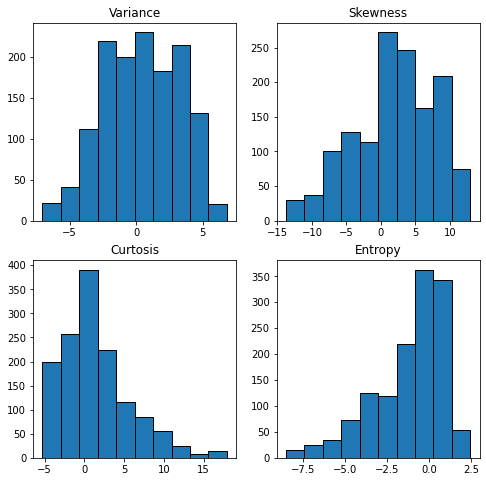

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.title('Variance')
plt.hist(data['variance'], edgecolor = "black")

plt.subplot(2, 2, 2)
plt.title('Skewness')
plt.hist(data['skewness'], edgecolor = "black")

plt.subplot(2, 2, 3)
plt.title('Curtosis')
plt.hist(data['curtosis'], edgecolor = "black")

plt.subplot(2, 2, 4)
plt.title('Entropy')
plt.hist(data['entropy'], edgecolor = "black")
plt.show()

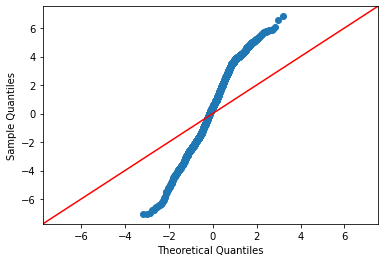

In [ ]:
sm.qqplot(data['variance'], line ='45')
plt.show()

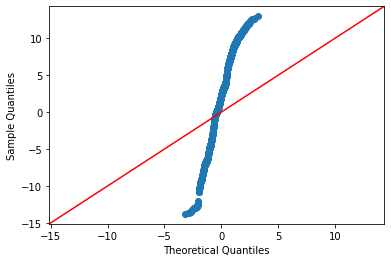

In [ ]:
sm.qqplot(data['skewness'], line ='45')
plt.show()

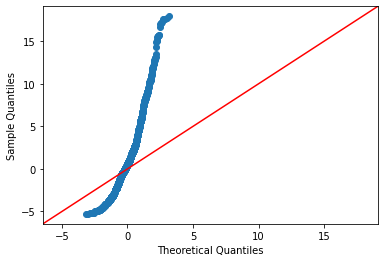

In [ ]:
sm.qqplot(data['curtosis'], line ='45')
plt.show()

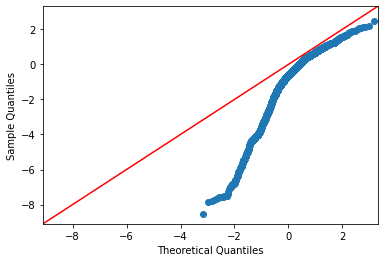

In [ ]:
sm.qqplot(data['entropy'], line ='45')
plt.show()

In [ ]:
data = data.sample(frac=1,random_state=0).reset_index(drop=True) # random shuffle
data.head()

,variance,skewness,curtosis,entropy,class
0,-1.7713,-10.766500,10.21840,-1.00430,1
1,5.1321,-0.031048,0.32616,1.11510,0
2,-2.0149,3.687400,-1.93850,-3.89180,1
3,1.4884,3.627400,3.30800,0.48921,0
4,5.2868,3.257000,-1.37210,1.16680,0


In [ ]:
X = data.iloc[:,:-1].values
label = data.iloc[:,4].values
N = X.shape[0]  # Number of data points
nc = X.shape[1]  # Number of features/components
print(X.shape)
print(np.unique(label))

(1372, 4)
[0 1]


In [ ]:
# Rescale the features of the data: substract the average and divide by the standard deviation
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

### 2. Unsupervised Learning

Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.

#### PCA

In [ ]:
Cov = np.matmul(X_scaled.transpose(), X_scaled)
lamb, v = LA.eigh(Cov)  # eigenvector and eigenvalues of the covariance matrix
idx = np.argsort(-lamb)
lambs = lamb[idx]
vs = v[:,idx]
print(lambs)
projection = np.matmul(X_scaled, vs)

[2990.82838913 1774.2085225   482.09669946  240.86638891]


In [ ]:
# Number of components depending on the explained variance threshold.
pca = PCA()
pca.fit(X_scaled)
cumul = np.zeros(nc)
for i in range(nc):
   cumul[i] = np.sum(pca.explained_variance_ratio_[:i+1])
lambs = pca.explained_variance_
comp = np.arange(nc) + 1

for t in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    nc = np.argmax(cumul - t > 0.) + 1
    print(t, nc)

0.8 2
0.85 2
0.9 3
0.95 3
0.97 4
0.99 4
0.999 4


In [ ]:
# two-nn estimator for intrinsic dimension
X_scaled_u = np.unique(X_scaled, axis=0)
dist = cdist(X_scaled_u, X_scaled_u)
dist.sort(axis=1)
mu_i = np.divide(dist[:, 2], dist[:, 1])
log_mu_i = np.log(mu_i)
two_nn = 1 / np.mean(log_mu_i)
print(two_nn)

2.3481336042537424


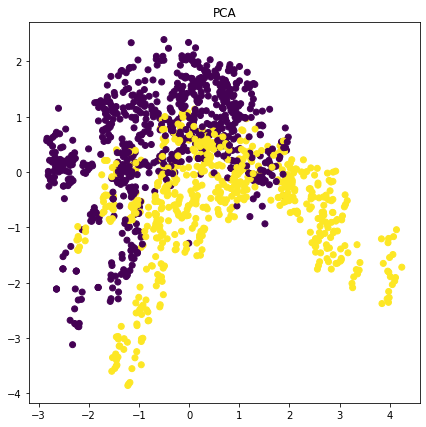

In [ ]:
# plotting the data set in 2D (i.e. keep only 2 PCs) colored by its ground truth label
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0],projection[:,1], c=label)
ax.set_title('PCA')
plt.show()

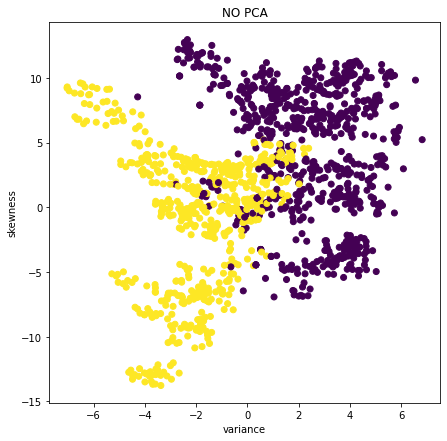

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0],X[:,1],c=label)
ax.set_title('NO PCA')
ax.set_xlabel('variance')
ax.set_ylabel('skewness')
plt.show()

#### K-means

In [ ]:
def k_means_internal(k, X, init):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    '''
    N = X.shape[0] # number of points
    nc = X.shape[1] # number of coordinates
    ll = np.arange(k)  # contenitore labels
    z = np.zeros(N, dtype='int') # cluster number assigned to each data point
    cent = np.zeros([k, nc]) # coordinates of the cluster centers
    # k-means++
    if (init=='++'):
        b = np.random.choice(N, 1, replace=False) # choose the first cluster center at random
        cent[0, :] = X[b, :]
        nchosen = 1 # number of cluster centers already set
        while (nchosen < k):
            dist = cdist(cent[:nchosen, :], X) # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0) # min distance btw point and cluster centers
            prob = dmin**2
            prob = prob/np.sum(prob)
            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob)
            cent[nchosen, :] = X[b,:]
            nchosen = nchosen + 1
    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly
        for i in ll:
            cent[i, :] = X[b[i],:]

    dist = cdist(cent, X)  # distance of each point from cluster centers
    z_new = np.argmin(dist, axis=0) # assign each point to cluster with closest center
    dmin = np.min(dist,axis=0)
    niter = 0
    L = np.sum((dmin)**2)
    while (z_new != z).any(): # until a stable configuration is reached
        z = np.copy(z_new)
        for i in range(k):
            cent[i, :] = np.average(X[z==i,:],axis=0) # compute cluster centroids
        dist = cdist(cent, X) # update distances from cluster centers
        z_new = np.argmin(dist, axis=0) # find cluster with min centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2) # loss function evaluation
        niter = niter + 1
    return (z_new, L, niter)

In [ ]:
def k_means(k, X, init='++', n_init=20):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    n_init : int
      Number of runs of the algorithms (with different initializations)
    '''
    lmin = 9.9*10**99
    for i in range(n_init):
        labels, loss, niter = k_means_internal(k, X_scaled, init=init)
        if (loss < lmin):  # store the best performing iteration
            lmin = loss
            labels_opt = labels
    return (labels_opt, lmin)

In [ ]:
two_dim_projection = projection[:,0:2]
kmeans_labels_2, l_kmeans_2 = k_means(2, X_scaled, init='++', n_init=20)

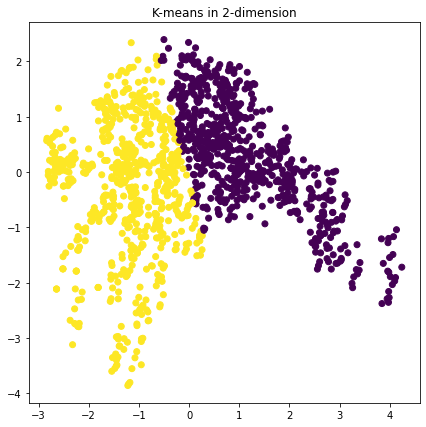

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(two_dim_projection[:,0], two_dim_projection[:,1], c=kmeans_labels_2)
ax.set_title('K-means in 2-dimension')
plt.show()

In [ ]:
kmeans_labels_4, k_lmin_4 = k_means(2, projection)

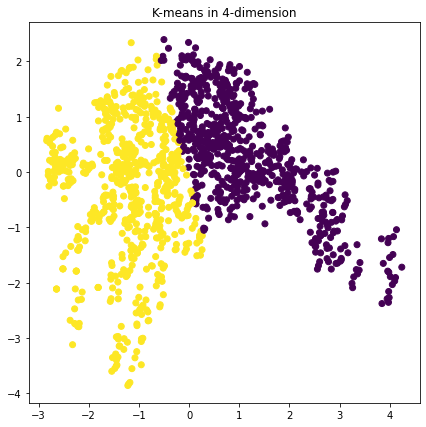

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0], projection[:,1], c=kmeans_labels_4)
ax.set_title('K-means in 4-dimension')
plt.show()

#### t-SNE

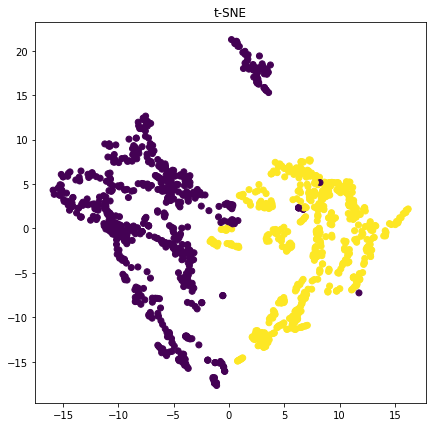

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=25).fit_transform(X_scaled)
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=label)
ax.set_title('t-SNE')
plt.show()

#### DBSCAN

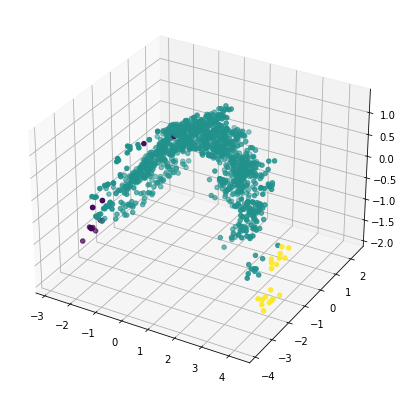

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=14).fit(X_scaled)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=dbscan.labels_)
plt.show()

### 3. Supervised Learning

Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN.

Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed.

Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?     


In [ ]:
train_data = data.iloc[372:,:]
test_data = data.iloc[:372,:]
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
X_test = test_data.iloc[:,:-1].values
y_test = test_data.iloc[:,-1].values

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1000, 5)
(372, 5)


In [ ]:
train_data.head()

,variance,skewness,curtosis,entropy,class
372,3.9663,10.16840,-4.11310,-4.60560,0
373,3.3397,-4.61450,3.98230,-0.23751,0
374,-6.1632,8.70960,-0.21621,-3.63450,1
375,2.8880,0.44696,4.59070,-0.24398,0
376,-2.5419,-0.65804,2.68420,1.19520,1


#### Logistic Regression

In [ ]:
LR = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', round(LR.score(X_test,y_test), 4))

Accuracy: 0.9866


In [ ]:
import numpy.linalg as LA

def sigmoidM(X, w):
    h = 1/(1+np.exp(-np.matmul(X,w)))
    return h

def LassoSquareLoss(X, labels, w, lam):
    n = np.shape(X)[0]
    L = -(1/n)*np.sum(labels*np.log(sigmoidM(X,w)) + (1-labels)*np.log(1-sigmoidM(X,w))) + lam*LA.norm(w,1)/n
    return L

def LogisticGradient(X, labels, w, points):
    return (1/points)*(np.transpose(X)@(sigmoidM(X,w)-labels))

def L1_subgradient(z):
    g = np.ones(z.shape)
    g[z < 0.] = -1.0
    return g

def LassoGradient(w, lam, points):
    return (lam * L1_subgradient(w)) / points

def GDLasso(X, labels, iter, gamma, d, lam, points):
    W = np.zeros((d,iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:,i] = w
        w = w - gamma * (LogisticGradient(X, labels, w, points) + LassoGradient(w, lam, points))
        L[i] = LassoSquareLoss(X,labels,w,lam)
    return W, L

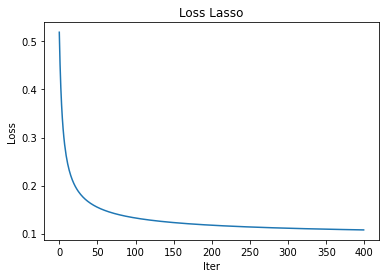

In [ ]:
d = np.shape(X)[1]
points = np.shape(X)[0]
iter = 400
gamma = 0.1
lam = 0.2

wgdL, L = GDLasso(X, label, iter, gamma, d, lam, points)

plt.plot(L)
plt.title('Loss Lasso')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = LR.predict(X_test)

target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       207
           1       0.97      1.00      0.99       165

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



In [ ]:
iter = 400
gamma = 0.1
lam = 0.2
wL,cL = GDLasso(X_train,y_train,iter, gamma, d, lam, points)
pesiL = wL[:,-1]
previsioniL = sigmoidM(X_test,pesiL)

yL_true = y_test
yL_pred = np.round(previsioniL)

target_names = ['0', '1']
print(classification_report(yL_true, yL_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       207
           1       0.98      0.92      0.95       165

    accuracy                           0.95       372
   macro avg       0.96      0.95      0.95       372
weighted avg       0.96      0.95      0.95       372



In [ ]:
iter = 400
gamma = 0.1
for i in (0.01, 0.05, 0.1, 0.5, 0.75, 1):
  wL,cL = GDLasso(X_train,y_train,iter, gamma, d, i, points)
  pesiL = wL[:,-1]
  previsioniL = sigmoidM(X_test,pesiL)

  yL_true = y_test
  yL_pred = np.round(previsioniL)

  target_names = ['0', '1']
  print(classification_report(yL_true, yL_pred, target_names=target_names))
  print('---------------------------------------------------------')

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       207
           1       0.98      0.92      0.95       165

    accuracy                           0.95       372
   macro avg       0.96      0.95      0.95       372
weighted avg       0.96      0.95      0.95       372

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       207
           1       0.98      0.92      0.95       165

    accuracy                           0.95       372
   macro avg       0.96      0.95      0.95       372
weighted avg       0.96      0.95      0.95       372

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       207
           1       0.98      0.92      0.95       165

    accuracy                           0.95       372
   macro avg

In [ ]:
iter = 400
lam = 0.1
for i in (0.001, 0.01, 0.05, 0.1, 0.5):
  wL,cL = GDLasso(X_train,y_train,iter, i, d, lam, points)
  pesiL = wL[:,-1]
  previsioniL = sigmoidM(X_test,pesiL)

  yL_true = y_test
  yL_pred = np.round(previsioniL)

  target_names = ['0', '1']
  print(classification_report(yL_true, yL_pred, target_names=target_names))
  print('---------------------------------------------------------')

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       207
           1       0.93      0.78      0.85       165

    accuracy                           0.88       372
   macro avg       0.89      0.87      0.87       372
weighted avg       0.88      0.88      0.87       372

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       207
           1       0.98      0.90      0.94       165

    accuracy                           0.95       372
   macro avg       0.95      0.94      0.94       372
weighted avg       0.95      0.95      0.95       372

---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       207
           1       0.98      0.91      0.94       165

    accuracy                           0.95       372
   macro avg

Area under curve=0.9999414434197043


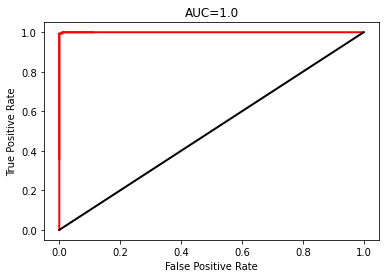

In [ ]:
def perf_metrics(y_actual, y_hat,threshold):
    tp = 0; fp = 0; tn = 0; fn = 0

    for i in range(len(y_hat)):
        if(y_hat[i][1] >= threshold):
            if(y_actual[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_hat[i][1] < threshold):
            if(y_actual[i] == 0):
                tn += 1
            else:
                fn += 1

    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)

    return [fpr,tpr]

pred = LR.predict_proba(X_test)
fpr,tpr =perf_metrics(y_test, pred,0.5)

#Now we calculate FPR and TPR for different thresholds and get AUC and ROC
thresholds = list(np.linspace(0,1,2000))

roc_points = []
for threshold in thresholds:
    rates = perf_metrics(y_test, pred, threshold)
    roc_points.append(rates)

fpr_array = []
tpr_array = []
for i in range(len(roc_points)-1):
    point1 = roc_points[i];
    point2 = roc_points[i+1]
    tpr_array.append([point1[0], point2[0]])
    fpr_array.append([point1[1], point2[1]])

#We use Trapezoidal rule to calculate the area under the curve and approximating the intergral
auc = sum(np.trapz(tpr_array,fpr_array))+1
print('Area under curve={}'.format(auc))

plt.plot(tpr_array,fpr_array, 'r', lw=2)
plt.plot([0, 1], [0, 1], 'k-', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={}'.format(round(auc,3)))
plt.show()

In [ ]:
!pip install scikit-plot
!python setup.py install

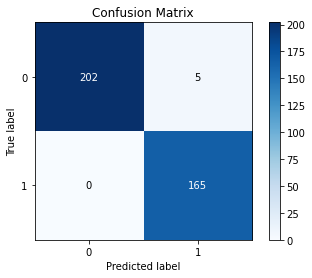

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test,y_pred)
plt.show()

#### ID3

In [ ]:
# compute H(S)
def entropy(train_data, label, class_list):
    total_row = train_data.shape[0]  # the total size of the dataset
    total_entr = 0
    for c in class_list:  # for each possible class in the label
        total_class_count = train_data[train_data[label] == c].shape[0]  # number of points belonging to the class
        if total_class_count > 0:
          total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row)  # entropy of the class
          total_entr += total_class_entr  # adding the class entropy to the total entropy of the dataset
    return total_entr

# compute H(S_j)
def feature_entropy(left_data, right_data, label, class_list):
    row_count = left_data.shape[0] + right_data.shape[0]
    p_left = left_data.shape[0] / row_count
    p_right = right_data.shape[0] / row_count
    ent = p_left * entropy(left_data, label, class_list) + p_right * entropy(right_data, label, class_list)
    return ent

def split(feature_column, threshold):
    left_rows = np.argwhere(feature_column <= threshold).flatten()
    right_rows = np.argwhere(feature_column > threshold).flatten()
    return left_rows, right_rows

def information_gain(data, feature_name, label, class_list, threshold):
    left_rows, right_rows = split(data[feature_name].values, threshold)
    if len(left_rows)==0 or len(right_rows)==0:
        return 0
    feat_entropy = feature_entropy(data.iloc[left_rows], data.iloc[right_rows], label, class_list)
    return feat_entropy

def get_split_thresholds(feature_column, n_thresholds):
    feature_column = feature_column.values
    n_data = len(feature_column)
    sorted_column = np.sort(feature_column)
    if len(feature_column) > 1:
        partitioned_array = np.array_split(feature_column, n_thresholds + 1)
        thresholds = [(partitioned_array[i][-1] + partitioned_array[i+1][0])/2 for i in range(len(partitioned_array)-1)]
    else:
        thresholds = [feature_column[0]]
    return thresholds

def most_informative_feature(train_data, label, class_list, n_thresholds):
    feature_list = train_data.columns.drop(label)
    min_entropy = 99999
    min_entropy_feature = None
    min_entropy_threshold = None
    for feature in feature_list:
        thresholds = get_split_thresholds(train_data[feature], n_thresholds)
        for t in thresholds:
            info_gain = information_gain(train_data, feature, label, class_list, t)
            if info_gain < min_entropy:
                min_entropy = info_gain
                min_entropy_feature = feature
                min_entropy_threshold = t
    return min_entropy_feature, min_entropy_threshold

def is_leaf(train_data, label):
    classes_in_node = np.unique(train_data[label])
    if len(classes_in_node) == 1:
        return True
    else:
        return False

def leaf_class(train_data, label):
    class_list, count_class = np.unique(train_data[label], return_counts=True)
    idx = count_class.argmax()
    return class_list[idx]

def make_tree(train_data, label, class_list, n_thresholds, cur_depth, min_samples, max_depth):

    if is_leaf(data, label) or cur_depth>=max_depth or len(train_data)<=min_samples:
        return leaf_class(train_data, label)
    else:
        cur_depth += 1
        split_feature, split_threshold = most_informative_feature(train_data, label, class_list, n_thresholds)
        left_rows, right_rows = split(train_data[split_feature].values, split_threshold)
        if len(left_rows)==0 or len(right_rows)==0:
            return leaf_class(train_data, label)
        else:
            # build sub tree
            split_condition = "{} <= {}".format(split_feature, split_threshold)
            sub_tree = {split_condition : []}
            # recursive call
            left_branch = make_tree(train_data.iloc[left_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
            right_branch = make_tree(train_data.iloc[right_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
            if left_branch == right_branch:
                sub_tree = left_branch
            else:
                # grow the tree
                sub_tree[split_condition].append(left_branch)
                sub_tree[split_condition].append(right_branch)
            return sub_tree

# id3 call
def id3(train_data_m, label, n_thresholds, min_samples, max_depth):
    train_data = train_data_m.copy()
    class_list = train_data[label].unique()
    tree = make_tree(train_data, label, class_list, n_thresholds, 0, min_samples, max_depth)  # start calling recursion
    return tree

In [ ]:
tree = id3(train_data, 'class', 1, 4, 6)
print(tree)

{'variance <= -2.7294799999999997': [{'variance <= -3.0074': [1, {'skewness <= -4.9466': [1, {'curtosis <= 3.651135': [1, 0]}]}]}, {'variance <= -0.39149': [{'skewness <= 3.5146550000000003': [{'curtosis <= 2.02575': [1, {'curtosis <= 6.6895': [1, {'skewness <= -3.9151': [1, 0]}]}]}, {'skewness <= 5.81465': [1, 0]}]}, {'curtosis <= -0.23719999999999986': [{'skewness <= 3.2518499999999997': [1, {'curtosis <= -2.66635': [{'variance <= 3.16445': [1, 0]}, 0]}]}, {'skewness <= -0.108645': [{'variance <= 1.8520960000000002': [{'curtosis <= 3.56155': [1, 0]}, 0]}, 0]}]}]}]}


In [ ]:
def predict(test_point, tree):
    if not isinstance(tree, dict):
        return tree
    question = list(tree.keys())[0]
    attribute, value = question.split(" <= ")
    if test_point[attribute] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
    return predict(test_point, answer)

def evaluate(tree, test_data, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index in range(len(test_data.index)):
        result = predict(test_data.iloc[index], tree)
        if result == test_data[label].iloc[index]:
            correct_preditct += 1
        else:
            wrong_preditct += 1
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)
    return accuracy

In [ ]:
accuracy = evaluate(tree, test_data, 'class')
accuracy

0.946236559139785

In [ ]:
for n_thresholds in (1,2,3,4):
    tree = id3(train_data, 'class', n_thresholds, 4, 6)
    accuracy = evaluate(tree, test_data, 'class')
    print('Accuracy with', n_thresholds, 'thresholds:', accuracy)

Accuracy with 1 thresholds: 0.946236559139785
Accuracy with 2 thresholds: 0.9865591397849462
Accuracy with 3 thresholds: 0.9865591397849462
Accuracy with 4 thresholds: 0.9946236559139785


In [ ]:
for min_samples in (4,8,12):
    tree = id3(train_data, 'class', 4, min_samples, 6)
    accuracy = evaluate(tree, test_data, 'class')
    print('Accuracy with', min_samples, 'minimum samples:', accuracy)

Accuracy with 4 minimum samples: 0.9946236559139785
Accuracy with 8 minimum samples: 0.9946236559139785
Accuracy with 12 minimum samples: 0.9946236559139785


In [ ]:
for max_depth in (4,6,8):
    tree = id3(train_data, 'class', 4, 4, max_depth)
    accuracy = evaluate(tree, test_data, 'class')
    print('Accuracy with maximum depth equal to', max_depth, ':', accuracy)

Accuracy with maximum depth equal to 4 : 0.9704301075268817
Accuracy with maximum depth equal to 6 : 0.9946236559139785
Accuracy with maximum depth equal to 8 : 0.989247311827957


In [ ]:
tree = id3(train_data, 'class', 4, 4, 6)
a = evaluate(tree, test_data, 'class')
print('Accuracy after cross validation:', a)

Accuracy after cross validation: 0.9946236559139785


#### Gaussian Naive Bayes

In [ ]:
def prior(train_data, label):
    priors = train_data.groupby(by=label).apply(lambda x: len(x)/len(train_data))
    return np.log(priors).values

def mean_variance(train_data, label):
    mean = train_data.groupby(by=label).apply(lambda x: x.mean(axis=0))
    variance = train_data.groupby(by=label).apply(lambda x: x.var(axis=0))
    return (mean.values, variance.values)

def gaussian_density(mean, variance, point):
    d = (1 / np.sqrt(2*np.pi*variance)) * np.exp((-(point - mean)**2) / (2*variance))
    return d

def train_gaussian_naive_bayes(train_data, label):
    mean, variance = mean_variance(train_data, label)
    priors = prior(train_data, label)
    unique_labels = train_data[label].unique()
    n_labels = len(unique_labels)
    return {'n_labels': n_labels, 'unique_labels': unique_labels, 'n_classes': n_labels, 'mean': mean,
           'variance': variance, 'prior': priors}

def posterior(point, mean, variance, class_list, n_classes, n_feat):
    posteriors = []
    for i in range(n_classes):
        posterior = 0
        for j in range(n_feat):
            posterior += np.log(gaussian_density(mean[i][j], variance[i][j], point[j]))
        posteriors.append(posterior)
    return posteriors

def predict(test_data, label, gauss_bayes):
    predictions = []
    n_feat = len(test_data.columns) - 1
    for i in range(len(test_data)):
        pr = gauss_bayes['prior']
        post = posterior(test_data.iloc[i, :-1], gauss_bayes['mean'], gauss_bayes['variance'],
                        gauss_bayes['unique_labels'], gauss_bayes['n_classes'], n_feat)
        prob = pr + post
        max_prob_class_idx = np.argmax(prob)
        predictions.append(gauss_bayes['unique_labels'][max_prob_class_idx])
    return predictions

def evaluate(test_data, label, gauss_bayes):
    gaus_pred = predict(test_data, label, gauss_bayes)
    correct_predict = 0
    wrong_predict = 0
    for index in range(len(test_data.index)):
        if gaus_pred[index] == test_data[label].iloc[index]:
            correct_predict += 1
        else:
            wrong_predict += 1
    accuracy = correct_predict / (correct_predict + wrong_predict)
    return accuracy

In [ ]:
gauss_bayes = train_gaussian_naive_bayes(train_data, 'class')

In [ ]:
accuracy = evaluate(test_data, 'class', gauss_bayes)
print('Accuracy with first 372 rows as test set::', accuracy)

Accuracy with first 372 rows as test set:: 0.8360215053763441


In [ ]:
X_GNB_train = data.iloc[:1000,:]
X_GNB_test = data.iloc[1000:,:]
GNB = train_gaussian_naive_bayes(X_GNB_train, 'class')
accuracy_last_372 = evaluate(X_GNB_test, 'class', GNB)
print('Accuracy with last 372 rows as test set:', accuracy_last_372)

Accuracy with last 372 rows as test set: 0.1774193548387097


#### k-NN

In [ ]:
from scipy.spatial.distance import euclidean

def distance(point_one, point_two):
    return euclidean(point_one, point_two)

def get_neighbors(train_set, test_point, label_col, n_neighbors):
    dist = np.array([distance(train_point, test_point) for train_point in train_set])
    idx_dist = dist.argsort()
    ordered_train = train_set[idx_dist, :]
    ordered_label = label_col[idx_dist]
    return ordered_train[:n_neighbors], ordered_label[:n_neighbors]

def predict(train_set, test_point, labels, n_neighbors):
    neigh, neigh_label = get_neighbors(train_set, test_point, labels, n_neighbors)
    values, counts = np.unique(neigh_label, return_counts=True)
    idx = np.argmax(counts)
    return values[idx]

def evaluate(train_set, test_set, label, n_neighbors):
    correct_preditct = 0
    wrong_preditct = 0
    train_labels = train_set[label].values
    train_set = train_set.drop(label, axis=1)
    test_labels = test_set[label].values
    test_set = test_set.drop(label, axis=1)
    for index in range(len(test_set.index)):
        result = predict(train_set.values, test_set.iloc[index].values, train_labels, n_neighbors)
        if result == test_labels[index]:
            correct_preditct += 1
        else:
            wrong_preditct += 1
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)
    return accuracy

In [ ]:
knn_accuracy = evaluate(train_data, test_data, 'class', 2)
print('Accuracy with 2 neighbors:', knn_accuracy)

Accuracy with 2 neighbors: 1.0


In [ ]:
for nb in (1,5,10,20,30,32,40):
    acc = evaluate(train_data, test_data, 'class', nb)
    print('Accuracy with', nb, 'neighbors:', acc)

Accuracy with 1 neighbors: 1.0
Accuracy with 5 neighbors: 1.0
Accuracy with 10 neighbors: 1.0
Accuracy with 20 neighbors: 0.9973118279569892
Accuracy with 30 neighbors: 0.9973118279569892
Accuracy with 32 neighbors: 0.9973118279569892
Accuracy with 40 neighbors: 0.9865591397849462
